In [1]:
# Importación de las librerías
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.models import Sequential, Model
# Sequential: API secuencial
# Model: API funcional
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Input
from tensorflow.keras import optimizers, backend
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Rutas de los datos de entrenamiento
ruta = '/content/drive/MyDrive/EuroSAT/'

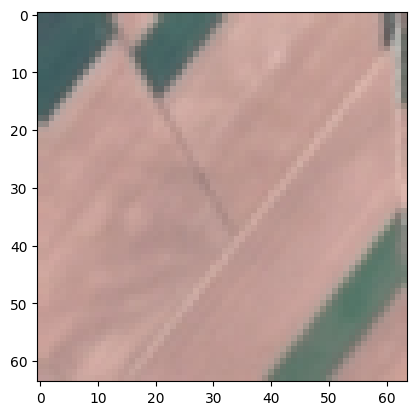

In [4]:
# Visualización de una imagen
imgTest = image_utils.load_img(ruta + 'Train/AnnualCrop/' + 'AnnualCrop_100.jpg')
plt.imshow(imgTest)
plt.show()

In [5]:
imgTest.size

(64, 64)

In [6]:
# Obtención de las clases
clases = os.listdir(ruta + 'Train')
print(clases)

['Forest', 'Residential', 'Pasture', 'HerbaceousVegetation', 'Industrial', 'PermanentCrop', 'SeaLake', 'AnnualCrop', 'River', 'Highway']


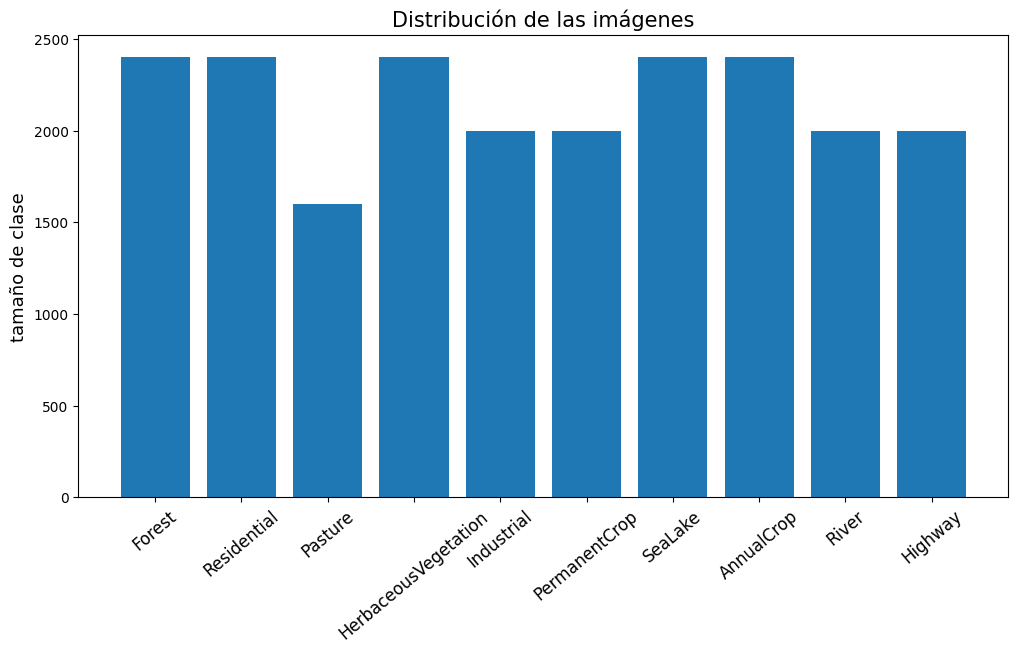

In [7]:
# Gráfica de la distribución de las clases
imgs_clase = {}

for clase in clases:
  imgs_clase[clase] = len(os.listdir(ruta + 'Train/' + clase))

plt.figure(figsize=(12, 6))
plt.bar(range(len(imgs_clase)), list(imgs_clase.values()), align='center')
plt.xticks(range(len(imgs_clase)), list(imgs_clase.keys()), fontsize=12, rotation=40)
plt.ylabel('tamaño de clase', fontsize=13)
plt.title('Distribución de las imágenes', fontsize=15);

In [8]:
# Variables auxiliares
TRAIN_DIR = '/content/drive/MyDrive/EuroSAT/Train'
TEST_DIR = '/content/drive/MyDrive/EuroSAT/Test'
BATCH_SIZE = 50
ANCHO = 64
ALTO = 64
CANALES = 3
NUM_CLASES = 10

In [9]:
# Generador de imágenes de keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
# Creación de una instancia de ImageDataGenerator para train

train_gen = ImageDataGenerator(rescale = 1/255)
                               # rotation_range = 50 (grados)
                               # width_shift_range = 0.1 (recorrer la imagen un poco)
                               # height_shift_range = 0.1 (recorrer la imagen un poco)
                               # horizontal_flip = True
                               # vertical_flip = True

train_generator = train_gen.flow_from_directory(
    directory = TRAIN_DIR,
    target_size = (ALTO, ANCHO),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True
)

# Creación de una instancia de ImageDataGenerator para test

test_gen = ImageDataGenerator(rescale = 1/255)

test_generator = train_gen.flow_from_directory(
    directory = TEST_DIR,
    target_size = (ALTO, ANCHO),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [11]:
# Cantidad de imágenes para train y test
TRAIN_SIZE = 21600
TEST_SIZE = 5400

Found 21600 images belonging to 10 classes.
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


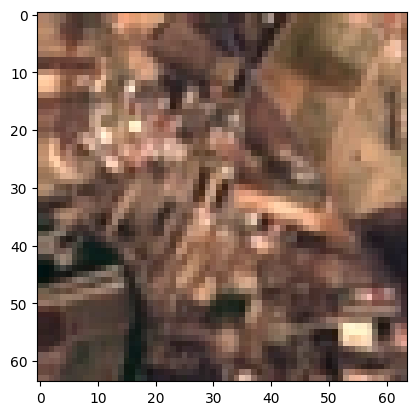

In [12]:
# Visualización de una imágen generada a partir de las originales
for x, y in train_gen.flow_from_directory(directory = TRAIN_DIR,
    target_size = (64, 64),
    batch_size = 1,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True):

    print(y)
    plt.imshow(image_utils.array_to_img(x.reshape(64,64,3)), cmap='Accent')
    plt.show()
    break

In [13]:
# Diccionario de clases
train_generator.class_indices

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [14]:
# Creamos un diccionario de numero de clase a palabra
clase2nombre = dict((indice, palabra) for (palabra, indice) in train_generator.class_indices.items())

In [15]:
clase2nombre[5]

'Pasture'

## 1- Modelo propio

In [16]:
# Escribe la línea de código que elimina información previa de los modelos
backend.clear_session()


In [17]:
# Define tu modelo
modeloIn = Input(shape=(ALTO, ANCHO, CANALES))
modelo = Conv2D(32, (3,3), activation = 'relu')(modeloIn)  # concatenado al modeloIn
modelo = MaxPool2D((2,2))(modelo)
modelo = Conv2D(64, (3,3), activation = 'relu')(modelo)
modelo = MaxPool2D((2,2))(modelo)
modelo = Conv2D(128, (3,3), activation = 'relu')(modelo)
modelo = MaxPool2D((2,2))(modelo)
modelo = Flatten()(modelo)
modelo = Dense(10, 'softmax')(modelo)
modeloConv = Model(inputs = modeloIn, outputs = modelo)

# Muestra la tabla con las características de tu modelo
modeloConv.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856 

In [18]:
# Define del optimizador Adam
adam = optimizers.Adam(learning_rate = 0.001)

In [19]:
# Compila el modelo
modeloConv.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [20]:
# # Entrenamiento del modelo
# MP = modeloConv.fit(train_generator,
#                     epochs = 3,
#                     steps_per_epoch = int(TRAIN_SIZE/BATCH_SIZE),
#                     validation_data = test_generator,
#                     validation_steps = int(TEST_SIZE/BATCH_SIZE),
#                     verbose = True
#                     )

# Entrenamiento del modelo
# MP = modeloConv.fit(train_generator,
#                     epochs = 2,
#                     steps_per_epoch = int(2),
#                     validation_data = test_generator,
#                     validation_steps = int(2),
#                     verbose = True
#                     )

# Entrenamiento del modelo
MP = modeloConv.fit(train_generator,
                    epochs = 3,
                    steps_per_epoch = 20, # int(TRAIN_SIZE/BATCH_SIZE),
                    validation_data = test_generator,
                    validation_steps = 20, # int(TEST_SIZE/BATCH_SIZE)
                    verbose = True
                    )

Epoch 1/3
20/20 [==============================] - 559s 28s/step - loss: 2.1775 - accuracy: 0.1320 - val_loss: 2.0447 - val_accuracy: 0.2750
Epoch 2/3
20/20 [==============================] - 483s 25s/step - loss: 1.8406 - accuracy: 0.3010 - val_loss: 1.6223 - val_accuracy: 0.4150
Epoch 3/3
20/20 [==============================] - 444s 23s/step - loss: 1.6052 - accuracy: 0.3580 - val_loss: 1.4253 - val_accuracy: 0.4270


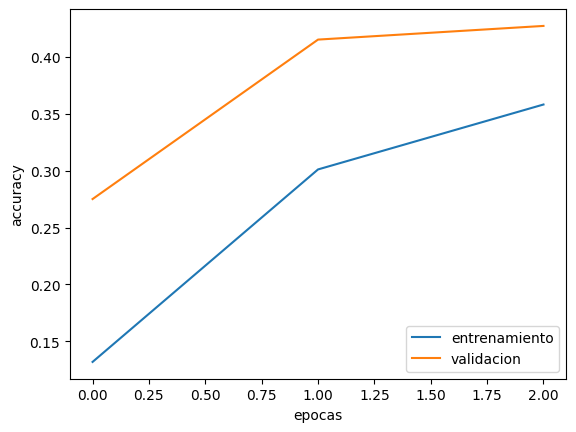

In [21]:
# Evaluación de la exactitud
plt.plot(MP.history['accuracy'], label='entrenamiento')
plt.plot(MP.history['val_accuracy'], label='validacion')
plt.legend(loc='lower right')
plt.xlabel('epocas')
plt.ylabel('accuracy')
plt.show()

## 2 - Transferencia de aprendizaje

In [22]:
from tensorflow.keras.applications import ResNet50
# VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50

In [23]:
# Creación de una instancia de ImageDataGenerator para train
train_gen = ImageDataGenerator(preprocessing_function = preprocess_resnet50)

train_generator_tf = train_gen.flow_from_directory(
    directory = TRAIN_DIR,
    target_size = (64, 64),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True,
    seed = 69
)

# Creación de una instancia de ImageDataGenerator para test
test_gen = ImageDataGenerator()

test_generator_tf = test_gen.flow_from_directory(
    directory = TEST_DIR,
    target_size = (64, 64),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True,
    seed = 69
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [24]:
backend.clear_session()

In [ ]:
# Librerías para transferencia de aprendizaje
# from tensorflow.keras import Model

In [25]:
# Modelo basado en Resnet 50
modeloResNet50_base = ResNet50(weights = 'imagenet', include_top = False, input_shape = (ALTO, ANCHO, CANALES))

94765736/94765736 [==============================] - 0s 0us/step


In [26]:
# Indicación para no entrenar las convolucionales en el modelo
for layer in modeloResNet50_base.layers:
  layer.trainable = False

In [27]:
# Definir las ultimas capas
modeloResNet50_intermedio_1 = modeloResNet50_base.output
modeloResNet50_intermedio_2 = Flatten()(modeloResNet50_intermedio_1)
modeloResNet50_intermedio_3 = Dense(10, activation = 'softmax')(modeloResNet50_intermedio_2)
# 2 capas dropout y dense y hacer otro entrenamiento para reducir el overfitting

In [28]:
# Crear el modelo completo
modeloResNet50 = Model(inputs = modeloResNet50_base.input, outputs = modeloResNet50_intermedio_3)
modeloResNet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [31]:
# Compila el modelo
adam = optimizers.Adam(learning_rate=0.001)

modeloResNet50.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy'])

# Define un checkpointer para guardar los pesos sinapticos de la red
# Guardar maximos de las epocas, guardar solo la mejor version
checkpointer = ModelCheckpoint('modeloRes50_v1.h5', monitor = 'val_accuracy', mode = 'max', save_best_only = True)

In [32]:
# Entrenamiento del modelo
MTF = modeloResNet50.fit(train_generator_tf,
                    epochs = 3,
                    steps_per_epoch = 20, # int(TRAIN_SIZE/BATCH_SIZE),
                    validation_data = test_generator_tf,
                    validation_steps = 20, # int(TEST_SIZE/BATCH_SIZE)
                    verbose = True
                    )

Epoch 1/3
20/20 [==============================] - 373s 19s/step - loss: 1.3813 - accuracy: 0.6760 - val_loss: 2.7038 - val_accuracy: 0.5030
Epoch 2/3
20/20 [==============================] - 342s 17s/step - loss: 0.7355 - accuracy: 0.8400 - val_loss: 3.1617 - val_accuracy: 0.4840
Epoch 3/3
20/20 [==============================] - 351s 18s/step - loss: 0.6133 - accuracy: 0.8710 - val_loss: 2.6989 - val_accuracy: 0.4990


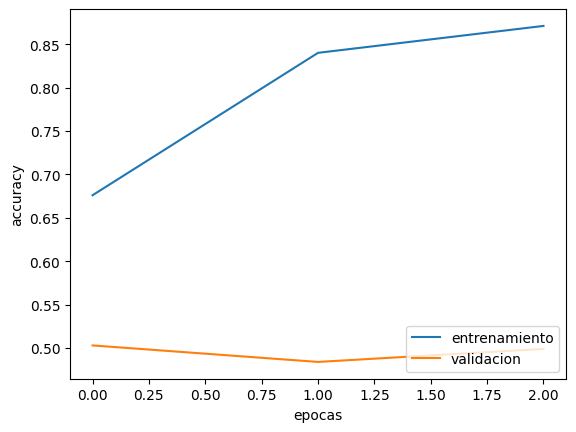

In [33]:
# Evaluación de la exactitud
plt.plot(MTF.history['accuracy'], label='entrenamiento')
plt.plot(MTF.history['val_accuracy'], label='validacion')
plt.legend(loc='lower right')
plt.xlabel('epocas')
plt.ylabel('accuracy')
plt.show()

## 3. Prueba sobre el modelo

In [ ]:
# Visualización de la imágen de test
imgVal = image_utils.load_img(ruta + )
plt.imshow()
plt.show()

In [ ]:
# Inferencia sobre la imagen
imgVal_pre =
imgVal_pre =
prediccion =
print('Prediccion con modelo preentrenado: ', np.argmax(prediccion))